In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

!pip install -U pandas
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.__version__

'1.3.5'

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/kaggle/project/allstate/train.csv.zip', index_col='id')
test=pd.read_csv('/content/drive/MyDrive/kaggle/project/allstate/test.csv.zip', index_col='id')
submission=pd.read_csv('/content/drive/MyDrive/kaggle/project/allstate/sample_submission.csv.zip', index_col='id')
print(train.shape, test.shape, submission.shape)

(188318, 131) (125546, 130) (125546, 1)


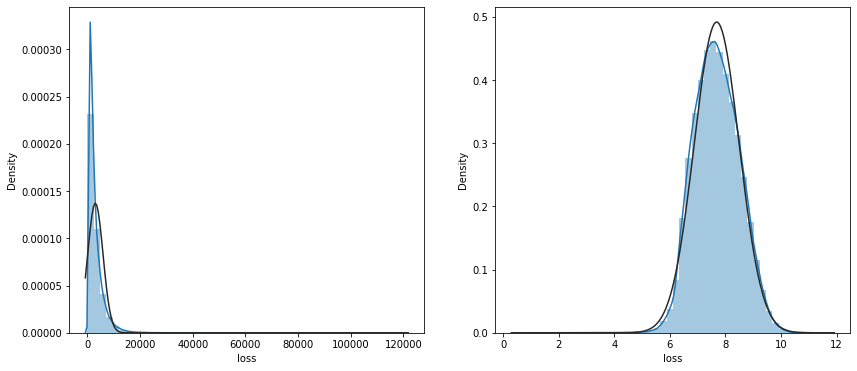

In [ ]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(train['loss'], fit=norm, ax=ax1)
sns.distplot(np.log(train['loss']+1), fit=norm, ax=ax2)

In [ ]:
train=train.drop(train.loc[train['loss']>40000].index)

train['loss']=np.log(train['loss']+1)
Ytrain=train['loss']

data=train
train=train[list(test)]
all_data=pd.concat((train, test))
all_data.shape

(313841, 130)

In [ ]:
cat_features=list(np.where(all_data.dtypes==np.object)[0])
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
non_numeric=list(all_data.select_dtypes(np.object))
for cols in non_numeric:
    le.fit(all_data[cols])
    all_data[cols]=le.transform(all_data[cols])

In [ ]:
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Ytrain.shape, Xtest.shape, submission.shape)

(188295, 130) (125546, 130)
(188295, 130) (188295,) (125546, 130) (125546, 1)


**Build Models**

In [ ]:
!pip install -U catboost
!pip install -U xgboost
!pip install lightgbm

In [ ]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
#import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(Xtrain, Ytrain,
                                                  test_size=0.2,
                                                  random_state=0)#,stratify=Ytrain)

**XG Boost**

In [ ]:
model_xgb=XGBRegressor(tree_method='gpu_hist', seed=18, objective='reg:linear', n_jobs=-1, verbosity=0,
                       colsample_bylevel=0.764115402027029, colsample_bynode=0.29243734009596956, 
                       colsample_bytree= 0.7095719673041723, gamma= 4.127534050725986, learning_rate= 0.02387231810322894, 
                       max_depth=14, min_child_weight=135, n_estimators=828,reg_alpha=0.3170105723222332, 
                       reg_lambda= 0.3660379465131937, subsample=0.611471430211575)
model_xgb

XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.764115402027029,
             colsample_bynode=0.29243734009596956,
             colsample_bytree=0.7095719673041723, enable_categorical=False,
             gamma=4.127534050725986, gpu_id=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02387231810322894,
             max_delta_step=None, max_depth=14, min_child_weight=135,
             missing=nan, monotone_constraints=None, n_estimators=828,
             n_jobs=-1, num_parallel_tree=None, objective='reg:linear',
             predictor=None, random_state=None, reg_alpha=0.3170105723222332,
             reg_lambda=0.3660379465131937, scale_pos_weight=None, seed=18,
             subsample=0.611471430211575, tree_method='gpu_hist',
             validate_parameters=None, verbosity=0)

**LightGBM**

In [ ]:
# model_LGB=LGBMRegressor(objective='regression_l1', random_state=18, subsample_freq=1,
#                         colsample_bytree=0.3261853512759363, min_child_samples=221, n_estimators=2151, num_leaves= 45, 
#                         reg_alpha=0.9113713668943361, reg_lambda=0.8220990333713991, subsample=0.49969995651550947, 
#                         max_bin=202, learning_rate=0.02959820893211799) #,device='gpu')
# model_LGB

# 5-fold CVモデルの学習
from sklearn.model_selection import KFold

# 【ブロック１：　初期化】
# 5つのモデルを保存するリストの初期化
model_LGB = []

# 学習用データでの予測値を保存するデータフレームの初期化
df_train_preds = pd.DataFrame({'y_train': y_train})

# 検証用データでの予測値を保存するデータフレームの初期化
df_eval_preds = pd.DataFrame({'y_eval': [],
                              'y_eval_pred': []})

# テストデータでの予測値を保存するデータフレームの初期化
df_test_preds = pd.DataFrame({'y_test': y_test})

# ラウンド数の初期化
round_no = 0

# 【ブロック２：　モデルの学習】
# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = KFold(n_splits=5, shuffle=True,  random_state=42)


# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'regression_l1',      # 目的関数：多値分類、マルチクラス分類
              'metric': 'mae',      # 分類モデルの性能を測る指標
              'learning_rate': 0.1,          # 学習率（初期値0.1）
              'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
              'random_state': 18,
              'subsample_freq': 1,
              'colsample_bytree': 0.3261853512759363,
              'min_child_samples': 221,
              'n_estimators':2151,
              'num_leaves': 45,
              'reg_alpha':0.9113713668943361,
              'reg_lambda': 0.8220990333713991,
              'subsample': 0.49969995651550947,
              'max_bin': 202,
              'learning_rate': 0.02959820893211799
             }
    
    # 学習
    evaluation_results = {}                              # 学習の経過を保存する箱
    model = lgb.train(params,                            # 上記で設定したパラメータ
                      lgb_train,                         # 使用するデータセット
                      num_boost_round=1000,              # 学習の回数
                      valid_names=['train', 'valid'],    # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],  # モデル検証のデータセット
                      evals_result=evaluation_results,   # 学習の経過を保存
                      early_stopping_rounds=20,          # アーリーストッピング
                      verbose_eval=0)                    # 学習の経過の非表示
    
    # 学習が終わったモデルをリストに保存
    model_LGB.append(model) 

**CatBoost**

In [ ]:
model_Cat=CatBoostRegressor(loss_function='MAE', random_seed=18, task_type='GPU', cat_features=cat_features, verbose=False,
                            iterations=2681, learning_rate=0.2127106032536721, depth=7, l2_leaf_reg=5.266150673910493, 
                            random_strength=7.3001140226199315, bagging_temperature=0.26098669708900213)
model_Cat

**Final Fit & Predict & Evaluation**

In [ ]:
#Final Fit
model_Cat.fit(Xtrain, Ytrain)
# model_LGB.fit(Xtrain, Ytrain)
model_xgb.fit(Xtrain, Ytrain)

#Predict
# lgb_predictions=model_LGB.predict(Xtest)
lgb_predictions = model.predict(Xtest, num_iteration=model.best_iteration)
cat_predictions=model_Cat.predict(Xtest)
xgb_predictions=model_xgb.predict(Xtest)

#Evaluation
# lgb_eval=model_LGB.predict(Xtrain)
lgb_eval=model.predict(Xtrain, num_iteration=model.best_iteration)
cat_eval=model_Cat.predict(Xtrain)
xgb_eval=model_xgb.predict(Xtrain)

# lgb_eval=np.exp(lgb_eval)-1
# cat_eval=np.exp(cat_eval)-1
# xgb_eval=np.exp(xgb_eval)-1

In [ ]:
predictions=(lgb_predictions + cat_predictions + xgb_predictions)/3

predictions=np.exp(predictions)-1
submission['loss']=predictions
submission.to_csv('/content/drive/MyDrive/kaggle/project/allstate/submission_1.csv')
submission.head()

,loss
id,
4,1508.694184
6,1876.937991
9,9763.615763
12,5939.971217
15,836.815780


**可視化※実装途中**

In [ ]:
#RMSE
from sklearn.metrics import mean_squared_error
mse_lgb = mean_squared_error(Ytrain, lgb_eval)
mse_cat = mean_squared_error(Ytrain, cat_eval)
mse_xgb = mean_squared_error(Ytrain, xgb_eval)

rmse_lgb=np.sqrt(mse_lgb)
rmse_cat=np.sqrt(mse_cat)
rmse_xgb=np.sqrt(mse_xgb)

print(rmse_lgb, rmse_cat, rmse_xgb)

0.5272049884070228 0.5182808876855234 0.5359064286550326


In [ ]:
#MAE
from sklearn.metrics import mean_absolute_error

mae_lgb = mean_absolute_error(Ytrain, lgb_eval)
mae_cat = mean_absolute_error(Ytrain, cat_eval)
mae_xgb = mean_absolute_error(Ytrain, xgb_eval)

print(mae_lgb, mae_cat, mae_xgb)

0.4005138849709814 0.39211837327647053 0.4152805092382009


In [ ]:
plt.scatter(Ytrain, lgb_eval)
plt.xlabel('True Values [loss]')
plt.ylabel('Predictions [loss]')

plt.axis('equal')
plt.axis('square')

plt.xlim([０, 1])
plt.ylim([0, 1])

# _ = plt.plot([-100, 100], [-100, 100])

SyntaxError: ignored

In [ ]:
plt.scatter(Ytrain, cat_eval)
plt.xlabel('True Values [loss]')
plt.ylabel('Predictions [loss]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
plt.scatter(Ytrain, xgb_eval)
plt.xlabel('True Values [loss]')
plt.ylabel('Predictions [loss]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
error = lgb_eval - Ytrain
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [RUL]")
plt.ylabel("Count")

In [ ]:
error = cat_eval - Ytrain
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [RUL]")
plt.ylabel("Count")

In [ ]:
error = xgb_eval - Ytrain
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [RUL]")
plt.ylabel("Count")